# Восстановление золота из руды

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Задачи:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from scipy import stats as st

Загрузим данные в переменные и посмотрим на размер датасетов

In [2]:
try:
    gold_train = pd.read_csv('gold_recovery_train_new.csv')
    gold_test = pd.read_csv('gold_recovery_test_new.csv')
    gold_full = pd.read_csv('gold_recovery_full_new.csv')
    print(gold_full.shape, gold_train.shape, gold_test.shape)
except:
    gold_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    gold_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    gold_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    print(gold_full.shape, gold_train.shape, gold_test.shape)

(19439, 87) (14149, 87) (5290, 53)


Посмотрим какие данные мы имеем

In [3]:
gold_full.info()
gold_full

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Посмотрим правильно ли рассчитана метрика recovery

Напишем функцию расчета эффективности обогащения 

In [4]:
def recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']

    try:
        recovery = (c * (f - t)) / (f * (c - t)) * 100
        if not 0 <= recovery <= 100:
            recovery = None
    except:
        recovery = None

    return recovery

In [5]:
calculated = gold_train.apply(recovery, axis=1).dropna()
existing = gold_train['rougher.output.recovery'].dropna()

mae = mean_absolute_error(calculated, existing)
print(f'MAE: {mae}')

MAE: 9.682896147825551e-15


Мы видим MAE близкое к нулю, а значит показатель рассчитан верно 

Приведем дату к нужному формату и сделаем индексацию в выборках по ее признаку

In [6]:
for i in (gold_train, gold_test, gold_full):
    i.index = pd.DatetimeIndex(i['date'])
    i = i.drop(['date'], axis=1, inplace=True)


Изучим недостающие данные в тестовом датасете

In [7]:
set(gold_train.columns) - set(gold_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Мы видим что пропущенные данные это параметры продукта и расчетные характеристики которые появляются в ходе процесса обогащения и не доступны на начальном этапе

Добавим в тестовую выборку таргеты

In [8]:
gold_test = gold_test.join(gold_full[['rougher.output.recovery', 'final.output.recovery']], on='date')
gold_train = gold_train[gold_test.columns]

gold_test.shape, gold_train.shape

((5290, 54), (14149, 54))

Посмотрим на кол-во пропусков

In [9]:
for i in (gold_train, gold_test, gold_full):
    print(i.isna().sum().sort_values(ascending=False).head(10),
    "\n-----------------------------------------------",
    f"\nПроцент пропусков в датасете {round(i.isna().sum().sum() / (i.shape[0] * i.shape[1]) * 100, 2)} %",
    "\n===============================================")

rougher.state.floatbank10_e_air             436
rougher.input.floatbank11_xanthate          428
secondary_cleaner.state.floatbank2_a_air    217
rougher.input.feed_size                     144
rougher.input.feed_pb                       100
primary_cleaner.input.xanthate              100
rougher.input.feed_sol                       78
rougher.input.floatbank11_sulfate            36
primary_cleaner.input.depressant             32
rougher.input.floatbank10_sulfate            29
dtype: int64 
----------------------------------------------- 
Процент пропусков в датасете 0.22 % 
rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
rougher.input.floatbank10_sulfate            5
primary_cleaner.input.sulfate                4
primary_cleaner.input.xanthate               4
secondary_cleaner.state.floatbank2_a_air    

Заполним пропуски методом ffill, так как соседние по времени параметры часто похожи

In [10]:
gold_test = gold_test.fillna(method='ffill')
gold_train = gold_train.fillna(method='ffill')
gold_full = gold_full.fillna(method='ffill')

for i in (gold_train, gold_test, gold_full):
    print(f"Процент пропусков в датасете {round(i.isna().sum().sum() / (i.shape[0] * i.shape[1]) * 100, 2)} %")
    

Процент пропусков в датасете 0.0 %
Процент пропусков в датасете 0.0 %
Процент пропусков в датасете 0.0 %


На данном этапе мы подготовили данные к дальнейшей работе: привели данные к нужному формату, убрали лишние признаки из тренировочной выборки и добавили таргеты в тестовую, а так же избавились от пропусков

Теперь можно приступать к анализу

## Анализ данных

### Концентрации металлов на этапах очистки 

Проанализируем концентрацию металлов на разных этапах очистки

Text(0.5, 0, 'этап очистки')

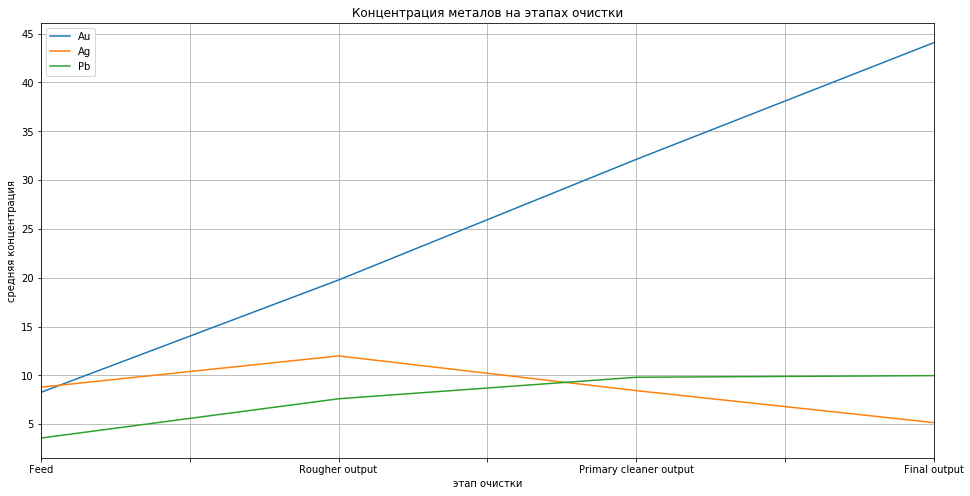

In [11]:
concentration = {}
for metal in ['au', 'ag', 'pb']:
    concentration.update(
        {f'{metal.capitalize()}': {
            'Feed': gold_full[f'rougher.input.feed_{metal}'].mean(),
            'Rougher output': gold_full[f'rougher.output.concentrate_{metal}'].mean(),
            'Primary cleaner output': gold_full[f'primary_cleaner.output.concentrate_{metal}'].mean(),
            'Final output': gold_full[f'final.output.concentrate_{metal}'].mean()
        }
        })

concentration = pd.DataFrame(concentration)
concentration.plot(figsize=(16, 8), grid=True)
plt.title('Концентрация металов на этапах очистки')
plt.ylabel('средняя концентрация')
plt.xlabel('этап очистки')

Мы видим, что концентрация золота растет от этапа к этапу, в то время как концентрация свинца останавливается на одном уровне после вторичной очистки, а концентрация серебра начинает уменьшаться уже после флотации

### Распределение размера гранул 

Построим график с распределениями размера гранул в тренировочной и тестовой выборках 

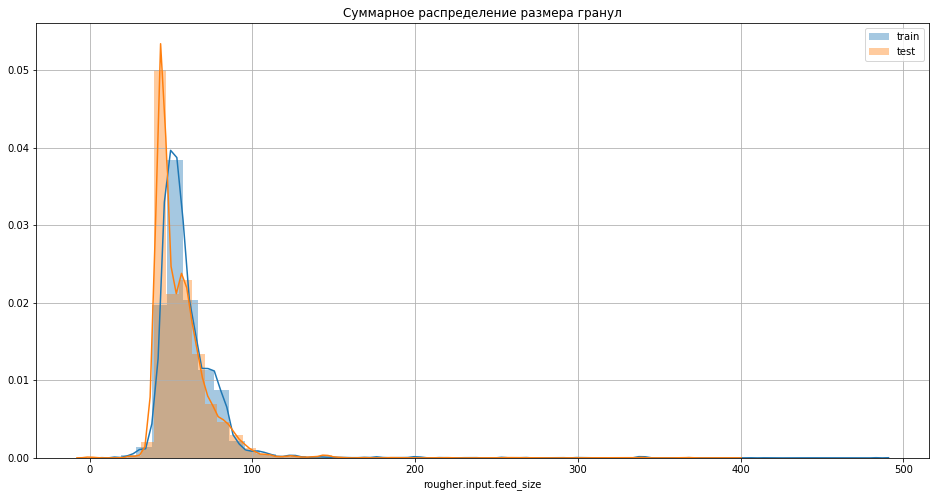

In [12]:
plt.figure(figsize=(16, 8))
sns.distplot(gold_train['rougher.input.feed_size'], label='train')
sns.distplot(gold_test['rougher.input.feed_size'], label='test')
plt.title('Суммарное распределение размера гранул')
plt.grid(True)
plt.legend()
plt.show()

Визуально распределения выглядят схоже, проверим гипотезу о равенстве двух средних генеральных совокупностей

In [14]:
alpha = .01
results = st.ttest_ind(gold_train['rougher.input.feed_size'], gold_test['rougher.input.feed_size'])
if (results.pvalue < alpha):
    print("Распределения размеров гранул в двух выборках не отличаются")
else:
    print("Распределения размеров гранул в двух выборках отличаются")

results.pvalue

Распределения размеров гранул в двух выборках не отличаются


1.6081245670847274e-33

### Суммарные концентрации металлов

Изучим суммарные концентрации металлов 

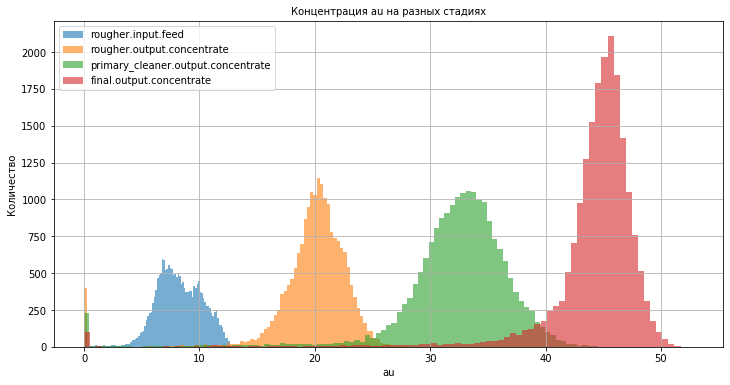

In [15]:
names = ['rougher.input.feed', 'rougher.output.concentrate', 
                     'primary_cleaner.output.concentrate', 'final.output.concentrate']

def hists(symbol, df):         
    for process in names:
        df[process+'_'+symbol].hist(bins=100, alpha=0.6, figsize=(12,6))
        plt.xlabel(symbol, fontsize=10)
        plt.ylabel('Количество', fontsize=10)
        plt.title('Концентрация '+ symbol + ' на разных стадиях', fontsize=10)
        plt.legend(names)

hists('au', gold_full)

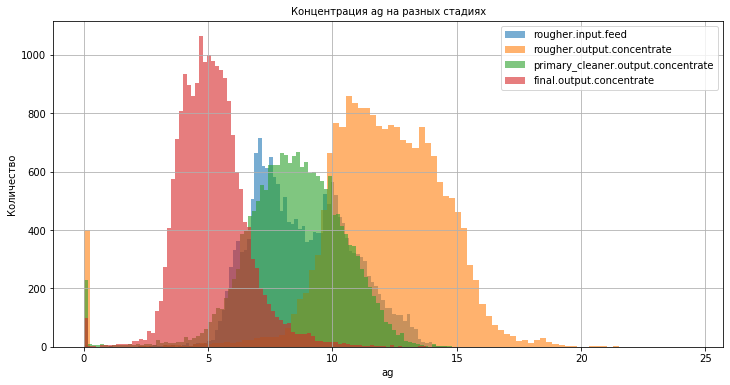

In [16]:
hists('ag', gold_full)

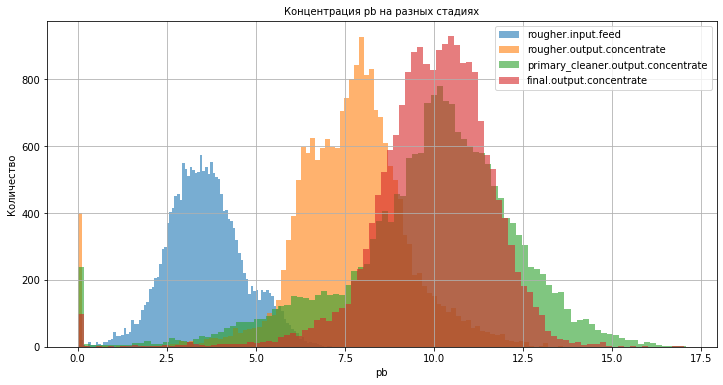

In [17]:
hists('pb', gold_full)

Мы видим что на всех этапах присутствуют выбросы около нуля, так как линейная регрессия чувствительна к выбросам мы должны убрать их

In [18]:
gold_full = gold_full.loc[(gold_full['rougher.input.feed_au'] >=1) & (gold_full['rougher.input.feed_ag'] >=1)
             & (gold_full['rougher.input.feed_pb'] >=1) & 
                 (gold_full['rougher.output.concentrate_au'] >=1) & (gold_full['rougher.output.concentrate_ag'] >=1)
             & (gold_full['rougher.output.concentrate_pb'] >=1) & 
                 (gold_full['primary_cleaner.output.concentrate_au'] >=1) & (gold_full['primary_cleaner.output.concentrate_ag'] >=1)
             & (gold_full['primary_cleaner.output.concentrate_pb'] >=1) & 
                 (gold_full['final.output.concentrate_au'] >=1) & (gold_full['final.output.concentrate_ag'] >=1)
             & (gold_full['final.output.concentrate_pb'] >=1)]
gold_train = gold_train[(gold_train['rougher.input.feed_au'] >=1) & (gold_train['rougher.input.feed_ag'] >=1)
             & (gold_train['rougher.input.feed_pb'] >=1)]
gold_test = gold_test[(gold_test['rougher.input.feed_au'] >=1) & (gold_test['rougher.input.feed_ag'] >=1)
             & (gold_test['rougher.input.feed_pb'] >=1)]

gold_full.shape, gold_train.shape, gold_test.shape

((18535, 86), (14000, 54), (5276, 54))

Посмотрим на графики после очистки 

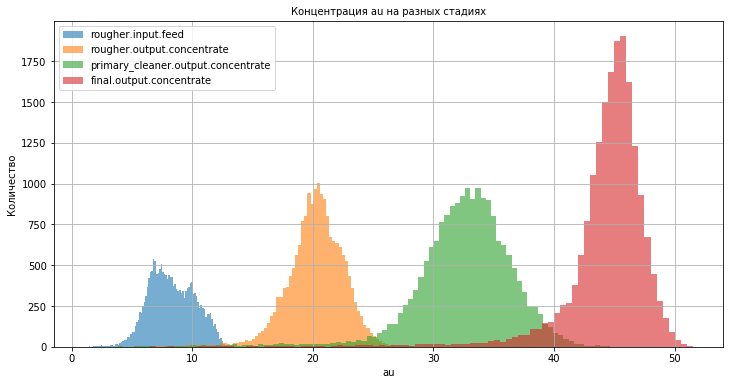

In [19]:
hists('au', gold_full)

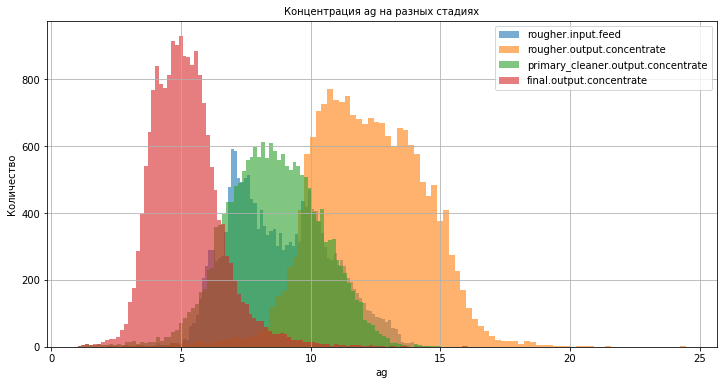

In [20]:

hists('ag', gold_full)

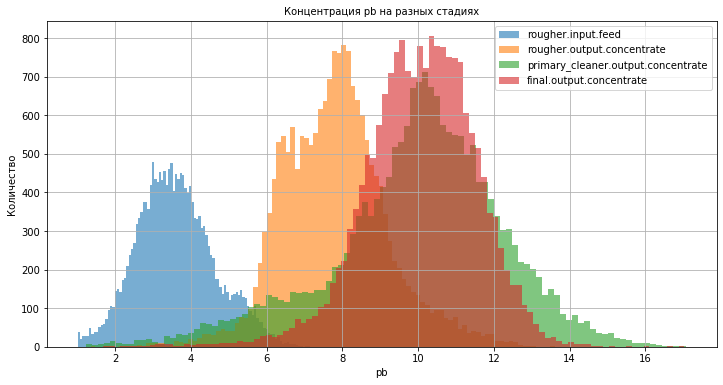

In [21]:
hists('pb', gold_full)

Мы проанализировали данные о концентрации металлов и размере гранул сырья, а так же избавились от аномалий и готовы переходить к построению моделей

## Модель

Расчитаем sMAPE и итоговый sMAPE, а так же напишем скорер для моделей

In [22]:
def smape(target, pred):
    return 1/len(target) * np.sum(np.abs(target - pred) / ((np.abs(target) + np.abs(pred)) / 2) * 100)

def smape_final(rougher, final):
    return 0.25 * rougher + 0.75 * final

def smape_final_scorer(target, pred):
    smapes = 1/len(target) * np.sum(np.abs(target - pred) / ((np.abs(target) + np.abs(pred)) / 2) * 100)
    rougher = smapes[0]
    final = smapes[1]
    return 0.25 * rougher + 0.75 * final

scorer = make_scorer(smape_final_scorer, greater_is_better=True)  

Разобьем выборки на фичи и таргеты, а так же стандартизируем наши признаки

In [23]:
features_train = gold_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = gold_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

target_train = gold_train[['rougher.output.recovery', 'final.output.recovery']]
target_test = gold_test[['rougher.output.recovery', 'final.output.recovery']]

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((14000, 52), (14000, 2), (5276, 52), (5276, 2))

In [24]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Обучим модели

In [25]:
tree_model = DecisionTreeRegressor(random_state = 2)

parameters={"splitter":["best","random"],
            "max_depth" : range(1, 5, 1),
           "min_samples_leaf": [3,5,7,9],
           "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5],
           "max_features": ["auto","log2","sqrt",None]}

best_tree = GridSearchCV(tree_model, parameters, scoring=scorer, cv=5,n_jobs=-1, verbose=True)
best_tree.fit(features_train, target_train)

display(best_tree.best_params_)
display(best_tree.best_score_)


Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  2.8min finished


{'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_weight_fraction_leaf': 0.2,
 'splitter': 'random'}

12.004884199393777

In [26]:
rf_model = RandomForestRegressor()
forest_params = {'n_estimators': [10, 50, 100, 150, 200, 250],
                'max_features' : [7, 10],
                'max_depth': [3, 4, 5],
                'random_state': [42]}

forest_grid = GridSearchCV(rf_model, forest_params, scoring=scorer, cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(features_train, target_train)

display(forest_grid.best_params_)
display(forest_grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 12.5min finished


{'max_depth': 3, 'max_features': 10, 'n_estimators': 10, 'random_state': 42}

10.332284110640822

Создадим константную модель и посчитаем целевой sMAPE

In [27]:
dummy = DummyRegressor(strategy='median')


dummy.fit(features_train, target_train)
dummy_predict = dummy.predict(features_test)
smape_dummy_rougher = smape(target_test, dummy_predict)
print(smape_dummy_rougher)
print('final smape', smape_final(smape_dummy_rougher[0], smape_dummy_rougher[1]))

rougher.output.recovery    8.543918
final.output.recovery      9.627631
dtype: float64
final smape 9.35670267713974


Протестируем модели и определим лучшую 

In [28]:
model_one = DecisionTreeRegressor(random_state=42, max_depth=2, max_features='sqrt', min_samples_leaf=3, min_weight_fraction_leaf=0.2)
model_one.fit(features_train, target_train)
model_one_pred = model_one.predict(features_test)

model_one_smape = smape(target_test, model_one_pred)
print(model_one_smape)
print('final smape', smape_final(model_one_smape[0], model_one_smape[1]))

rougher.output.recovery    9.245970
final.output.recovery      9.421125
dtype: float64
final smape 9.377336089128242


In [29]:
model_two = RandomForestRegressor(random_state=42, n_estimators=10, max_depth=3, max_features=10)
model_two.fit(features_train, target_train)
model_two_pred = model_two.predict(features_test)

model_two_smape = smape(target_test, model_two_pred)
print(model_two_smape)
print('final smape', smape_final(model_two_smape[0], model_two_smape[1]))

rougher.output.recovery    9.226217
final.output.recovery      8.905565
dtype: float64
final smape 8.985728214149315


In [30]:
model_three = LinearRegression()
model_three.fit(features_train, target_train)
model_three_pred = model_three.predict(features_test)

model_three_smape = smape(target_test, model_three_pred)
print(model_three_smape)
print('final smape', smape_final(model_three_smape[0], model_three_smape[1]))

rougher.output.recovery    9.740706
final.output.recovery      9.863882
dtype: float64
final smape 9.833088049076608


Лучше всего себя показал случайный лес, а так же он преодолел константную sMAPE

## Общий вывод

В ходе работы были изучены данные с параметрами добычи и очистки золотосодержащей руды. Было установлено, что концентрация золота растёт на всех этапах обработки. Концентрация свинца возрастает до 2 этапа очистки, а концентрация серебра растет только после флотации, на последующих этапах падает. Были обнаружены наблюдения с аномальными значениями концентрации руды , а также аномальными значениями размеров гранул сырья. Эти наблюдения были удалены во всех выборках.

На основе данных обучающей выборки были построены модели решающего дерева, случайного леса и линейной регрессии. Наилучшее значение целевой метрики показала модель случайного леса, так же модель прошла проверку на адекватность.